In [1]:
import tensorflow as tf
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from tensorflow.keras import layers, models
import pickle
import json

In [2]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("GPU not found. Go to Runtime > Change runtime type > GPU")

GPU detected: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/MLHD_Project/Data/processed_dataset.zip" -d "/content"

In [5]:
PROJECT_DIR = "/content/drive/MyDrive/MLHD_Project"
PROCESSED_DATA_DIR = "/content/processed_dataset"

with open(PROJECT_DIR + "/Data/class_weights.pkl", "rb") as f:
    class_weights = pickle.load(f)

with open(PROJECT_DIR + "/Data/label_to_index.pkl", "rb") as f:
    label_to_index = pickle.load(f)

with open(PROJECT_DIR + "/Data/index_to_label.pkl", "rb") as f:
    index_to_label = pickle.load(f)

In [6]:
def load_dataset(split_path, label_to_index, input_shape=(40, 101), shuffle=True):
    data = []
    labels = []

    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if not fname.endswith(".npy"):
                continue

            file_path = os.path.join(label_path, fname)
            spectrogram = np.load(file_path).astype(np.float32)

            # Ensure shape matches
            if spectrogram.shape != input_shape:
                print(f"Skipping {file_path} due to shape mismatch: {spectrogram.shape}")
                continue

            data.append(spectrogram)
            labels.append(label_to_index[label])

    data = np.array(data)[..., np.newaxis]  # Add channel dim
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))

    return dataset

In [7]:
train_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "train"), label_to_index)
val_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "val"), label_to_index, shuffle=False)
test_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "test"), label_to_index, shuffle=False)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
class CNNBiLSTMModel:
    def __init__(self, input_shape=(40, 101, 1), num_classes=12,
                 lstm_units=32, dense_units=64, dropout_rate=0.3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.model = self._build_model()

    def _build_model(self):
        inputs = tf.keras.Input(shape=self.input_shape)

        # CNN Layers
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

        # Reshape
        x = layers.Reshape((10, 800))(x)

        # Feature Compression
        x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)

        # BiLSTM with return_sequences
        x = layers.Bidirectional(
            layers.LSTM(self.lstm_units, return_sequences=True)
        )(x)

        # Pooling across time
        x = layers.GlobalAveragePooling1D()(x)

        # Dropout + Classifier
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(self.dense_units, activation='relu')(x)
        x = layers.Dropout(self.dropout_rate / 1.5)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        return models.Model(inputs, outputs)

    def compile(self, learning_rate=0.001):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def get_model(self):
        return self.model

In [9]:
cnn_bilstm = CNNBiLSTMModel(input_shape=(40, 101, 1), num_classes=len(label_to_index))
cnn_bilstm.compile()
model = cnn_bilstm.get_model()
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=20,
            class_weight=class_weights)

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.1552 - loss: 3.0244 - val_accuracy: 0.5620 - val_loss: 1.4744
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - accuracy: 0.5428 - loss: 1.5116 - val_accuracy: 0.7086 - val_loss: 0.9599
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.6591 - loss: 1.1187 - val_accuracy: 0.7654 - val_loss: 0.7682
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.7178 - loss: 0.9161 - val_accuracy: 0.8009 - val_loss: 0.6696
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.7620 - loss: 0.7822 - val_accuracy: 0.8108 - val_loss: 0.6214
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.7850 - loss: 0.6977 - val_accuracy: 0.8328 - val_loss: 0.5534
Epoch 7/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.8038 - loss: 0.6376 - val_accuracy: 0.7780 - val_loss: 0.7256
Epoch 8/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.8163 -

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8571 - loss: 0.4908

Test accuracy: 0.8594
Test loss: 0.4945


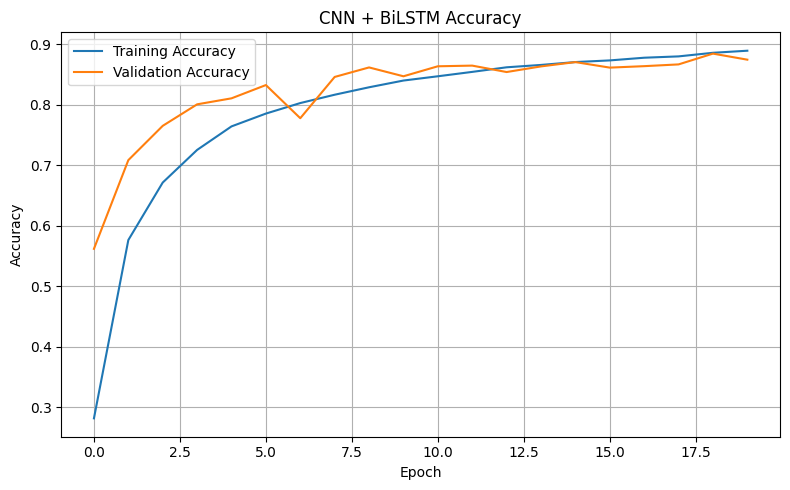

In [11]:
history_dict = history.history
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/cnn_bilstm_accuracy.png")
plt.show()

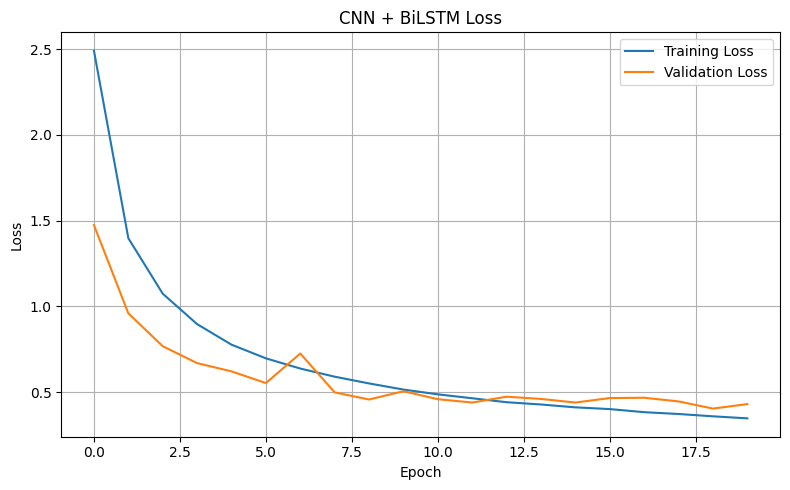

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('CNN + BiLSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/cnn_bilstm_loss.png")
plt.show()

In [13]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8702 - loss: 0.4297

Validation accuracy: 0.8748
Validation loss: 0.4307


In [14]:
model_name = "cnn_bilstm"
drive_dir = f"/content/drive/MyDrive/MLHD_Project/{model_name}"
os.makedirs(drive_dir, exist_ok=True)

model.save(os.path.join(drive_dir, f"{model_name}_model.keras"))
model.save_weights(os.path.join(drive_dir, f"{model_name}.weights.h5"))

history_path = os.path.join(drive_dir, "training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

metadata = {
    "model_name": model_name,
    "epochs": len(history.history["accuracy"]),
    "final_train_acc": round(history.history["accuracy"][-1], 4),
    "final_val_acc": round(history.history["val_accuracy"][-1], 4),
    "input_shape": model.input_shape,
    "output_shape": model.output_shape,
    "num_params": model.count_params(),
}
metadata_path = os.path.join(drive_dir, f"metadata_{model_name}.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40, 101, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 40, 101, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 101, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 50, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 800)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 64)              │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 35)                  │           2,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,379 (1.00 MB)

 Trainable params: 87,427 (341.51 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 174,856 (683.04 KB)